Первым делом мы импортируем необходимые нам библиотеки. В общем и целом - NumPy и Pandas; графические библиотеки seaborn и matplotlib; библиотека для машинного обучения sklearn.

In [28]:
import numpy as np #линейная алгебра
import pandas as pd #обработка датафреймов, импорт .csv файлов

import seaborn as sns #красивые графики
import matplotlib.pyplot as plt #матплотлиб 
#выводит картинку прямо в среде ноутбука
%matplotlib inline
plt.style.use('seaborn-notebook') #наводит красоту в графиках
from matplotlib.ticker import StrMethodFormatter #способ подписывать оси хз зачем скопировала

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

Создадим два датафрейма, прочтя имеющиеся .csv-файлы. Напомним, что на трейн.цсв будет вестись обучение, а тест.цсв - для осуществления предсказания.

In [29]:
train_df = pd.read_csv('train.csv') #прочитали табличку трейн
test_df = pd.read_csv('train.csv') #прочитали табличку тест

Посмотрим на наши красивые датафреймы (а точнее, на первые пять строчек датафреймов).

In [30]:
train_df.head() #вывели 5 верхних 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Выведем и разберём названия столбцов. PassengerId - идентификационный номер пассажира, Survived - выжил человек или нет; принимает значения либо 0 либо 1, Pclass - данные о том, каким классом ехал человек; принимает значения 1, 2 и 3, Name - очев, Sex - очев, Age - очев, SibSp - суммарное количество сиблингов/супругов на борту, Parch - число родителей/детей на борту, Ticket - серийный номер билета, Fare - стоимость билета, Cabin - номер каюты, Embarked - то, где должен был выйти человек (или зайти, мы так и не поняли); принимает значения S, C, Q.

In [32]:
train_df.columns #вывели названия колонок

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Начнём обрабатывать данные в датафрейме. Начнём с влияния патриархата.

Для начала посмотрим на долю выживших женщин и мужчин.

In [33]:
women = train_df.loc[train_df.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("доля выживших женщин:", rate_women)

men = train_df.loc[train_df.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("доля выживших мужчин:", rate_men)

доля выживших женщин: 0.7420382165605095
доля выживших мужчин: 0.18890814558058924


Неприятно...

Теперь давайте поговорим о возрасте. Кажется, в начале 20го века, многим было плевать на возраст. Плюс не у всех этот возраст можно было установить. Поэтому мы выполнили проверку на наличие "пустых" ячеек (NaNов, но зачем-то этот кусок кода удалили. Надо как-то заполнить эти пустые ячейки! Мы создали массив из рандомных, но приближенных к реальности (случайные числа в диапазоне от среднее-стандартное отклонение до среднее+стандартное отклонение)возрастов и вставили их в ячейки обоих датафреймов вместо NaNов.

In [34]:
data = [train_df, test_df]
for dataset in data:
    mean = train_df["Age"].mean() #средний возраст
    std = train_df["Age"].std() #стандартное отклонение по возратсу
    is_null = dataset["Age"].isnull().sum() #проверка наличия пустых ячеек возраста
    rand_age = np.random.randint(mean - std, mean + std, size = is_null) #заполняем пустые ячейки случайным возрастом
    #ебёмся с копиями датафрейма потому что нихуя не работало
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age #там где в возрасте стоит нан (пустая ячейка) мы вставляем массви рандомного возраста (
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

Теперь, когда у нас есть распределение по полу и возрасту, нарисуем гистограммы - сколько женщин и мужчин определённого возраста выжили, а сколько нет.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

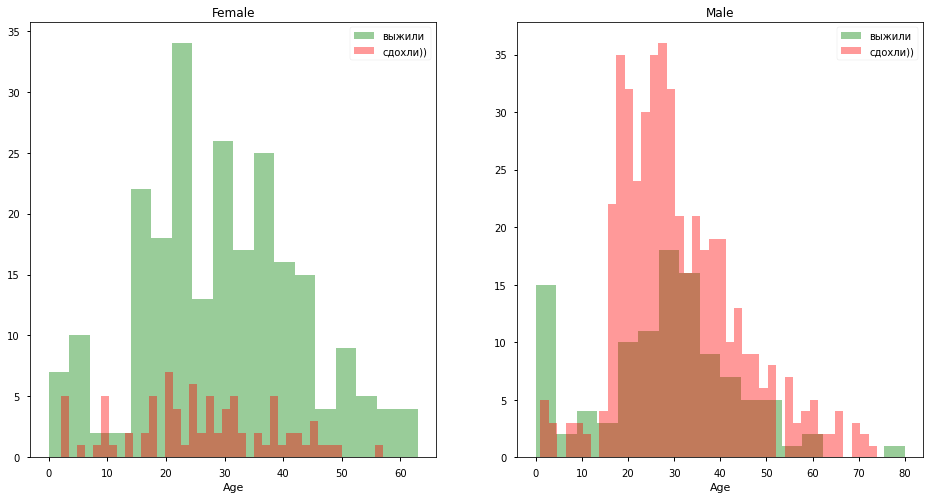

In [35]:
survived = 'выжили'
not_survived = 'сдохли))'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

Предварительно это можно интерпретировать следующим образом: в первую очередь спасали на Титанике женщин, детей и стариков. А на мужчин в среднем возрасте всем было всё равно. Вот такое вот у нас общество.

Теперь построим графики для двух гендеров, где отметим точки-людей. По оси Х отложен айди пассажира, по У - возраст,рыжим отмечены выжившие, а синим - погибшие.

[]

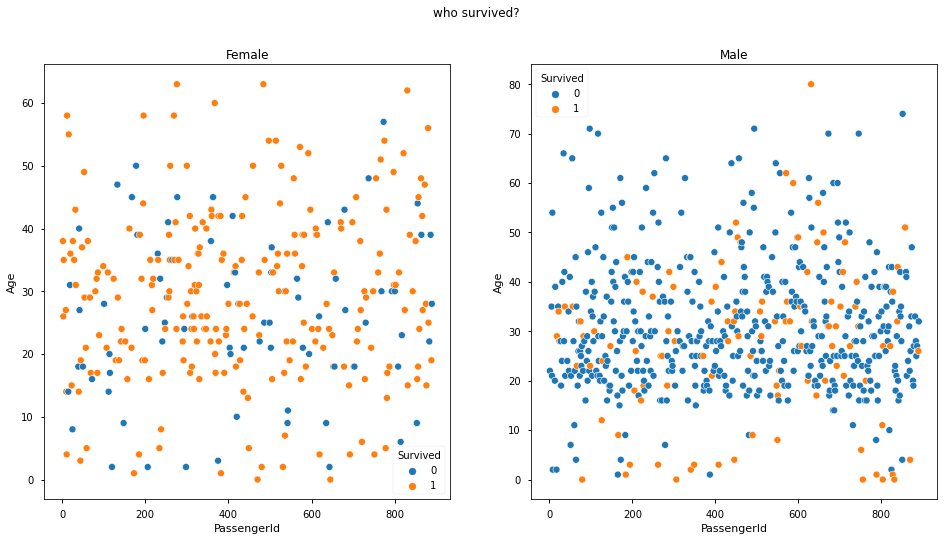

In [36]:
plt.figure(figsize=(16, 8))
plt.suptitle('who survived?')

plt.subplot(1, 2, 1)
fig_female = sns.scatterplot(x="PassengerId", y="Age", hue="Survived", data=train_df[train_df["Sex"] == "female"])

plt.subplot(1, 2, 2)
fig_male = sns.scatterplot(x="PassengerId", y="Age", hue="Survived", data=train_df[train_df["Sex"] == "male"])

fig_female.title.set_text('Female')
fig_male.title.set_text('Male')

plt.plot()

Вот что можно сказать о гендерно-возрастном распределении.

Теперь обработаем данные из столбцов "Embarked", класса путешествия и пола. И посмотрим на среднюю выживаемость.
Для начала заполним пустые ячейки в столбце "Embarked". Для этого просто возьмём моду и заполним пустые ячейки самым часто встречаемым значением.
Затем построим три графика (для трёх значений "Embarked"). По оси Х - номер класса, по оси У - доля выживших, синим обозначены женщины, а чёрным мужчины.

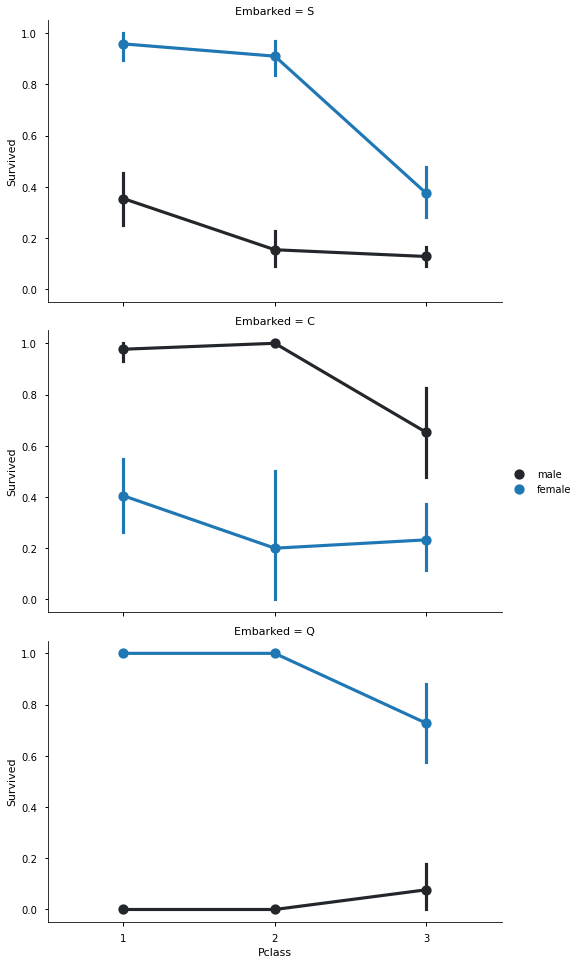

In [37]:
#где сели, класс, пол, средняя выживаемость

embarked_mode = train_df['Embarked'].mode() #мода (самое частое)
data = [train_df, test_df]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)#заполняем наны модой

FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

Вот что у нас получается:

In [38]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Теперь начнём обучать (напомню, что мы используем в качестве модели обучения k Nearest Neighbours). В качестве важных черт для обучения (точнее, какие характеристики пассажиров скорее всего повлияли на то, удалось им выжить или нет (взяли их на шлюпку или нет)) мы взяли следующие: "Age", "SibSp", "Parch", "Fare", "Pclass", "Sex", "Embarked". Очевидно, что айди, имя, номер билета и номер каюты скорее всего никак не повлияли. 

Но сначала предподготовка. Вышеупомянутые черты мы поделили на численные и категориальные (и будем применять к ним разные методыи функции из библиотеки sklearn). Для численных характеристик мы применяли функцию StandartScaler (стандартизация как метод масштабирования), а для категориальных - функцию OneHotEncoder (нолик или единичка для каждой вариации признака).

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_feats = ["Age", "SibSp", "Parch", "Fare"]
cat_feats = ["Pclass", "Sex", "Embarked"]

ct = ColumnTransformer([
  ("num", StandardScaler(), num_feats),
  ("cat", OneHotEncoder(drop="if_binary"), cat_feats),
], remainder="drop")

Подготовленные данные делаем так. X - набор черт по которым предсказываем, У - черта которую предсказываем. fit мы не используем в тесте чтобы не лохануться с порядком столбцов? 7 7 ? НА НПащуыниасдщРИстзШЖ

In [40]:
X_train = ct.fit_transform(train_df)
X_test = ct.transform(test_df)

In [41]:
y_train = np.array(train_df["Survived"])
y_test = np.array(test_df["Survived"])

Надо подобрать хорошие параметры для метода k ближайших соседей. Делать это мы будем разделив наши тренировочные данные на 5 частей и кросс-валидировать между частями (чтобы не париться с другими данными). Что мы подбираем? Оптимальное число соседей, метрику (евклидову или манхэттенскую) и что играет бОльшую роль - количество соседей или близость к соседу.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

clf = GridSearchCV(
    KNeighborsClassifier(),
    {"n_neighbors": [3, 5, 7, 10, 20, 50, 100], "p": [1, 2], "weights": ["distance", "uniform"]},
    cv=5,
)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 10, 20, 50, 100], 'p': [1, 2],
                         'weights': ['distance', 'uniform']})

А вот и оптимальные параметры

In [43]:
clf.best_params_

{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

Посчитаем точность обучения и предсказания:

In [44]:
from sklearn.metrics import accuracy_score

print(f"Train accuracy: {accuracy_score(y_train, clf.predict(X_train))}")
print(f"Test accuracy: {accuracy_score(y_test, clf.predict(X_test))}")

Train accuracy: 0.8462401795735129
Test accuracy: 0.8383838383838383


Дальше внесём в наш датафрейм итоги предсказания

In [45]:
test_df['Survived'] = clf.predict(X_test)
test_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


И, наконец, запишем всё в новый .csv файл

In [46]:
result_test_df = test_df.copy()
result_test_df.to_csv(r'result_test.csv', index=False)